In [16]:
import pyuvdata
import numpy as np
import sys
sys.path.append("/Users/ruby/Astro/rlb_LWA/beam_manipulation")
import jones_to_mueller
import importlib
importlib.reload(jones_to_mueller)
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
#beam_path = "/Users/ruby/Astro/Nivedita_beams/LWA_10to100.beamfits"
beam_path = "/Users/ruby/Astro/Nivedita_beams/LWA_10to100_MROsoil_efields.fits"
beam = pyuvdata.UVBeam()
beam.read(beam_path)
beam.select(axis2_inds=np.where(beam.axis2_array <= np.pi/2)[0])
beam.peak_normalize()

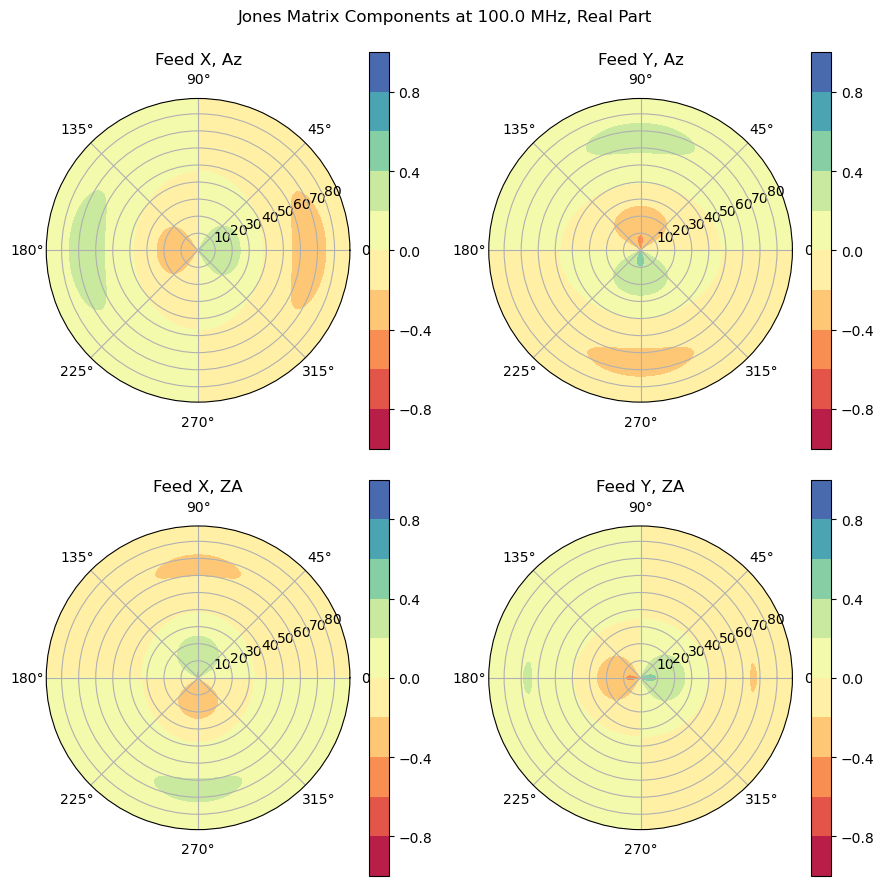

In [3]:
jones_to_mueller.plot_beam(beam, plot_freq=100.0e6)

In [4]:
# Beam manipulations
beam_radec = jones_to_mueller.pol_basis_transform_azza_to_radec(beam, latitude=37.23, inplace=False)
mueller_coherency = jones_to_mueller.convert_jones_to_mueller(beam_radec)
mueller_stokes = jones_to_mueller.pol_basis_transform_radec_to_stokes(mueller_coherency, inplace=False)
mueller_pstokes = jones_to_mueller.pol_basis_transform_instrumental_to_pseudostokes(mueller_stokes)

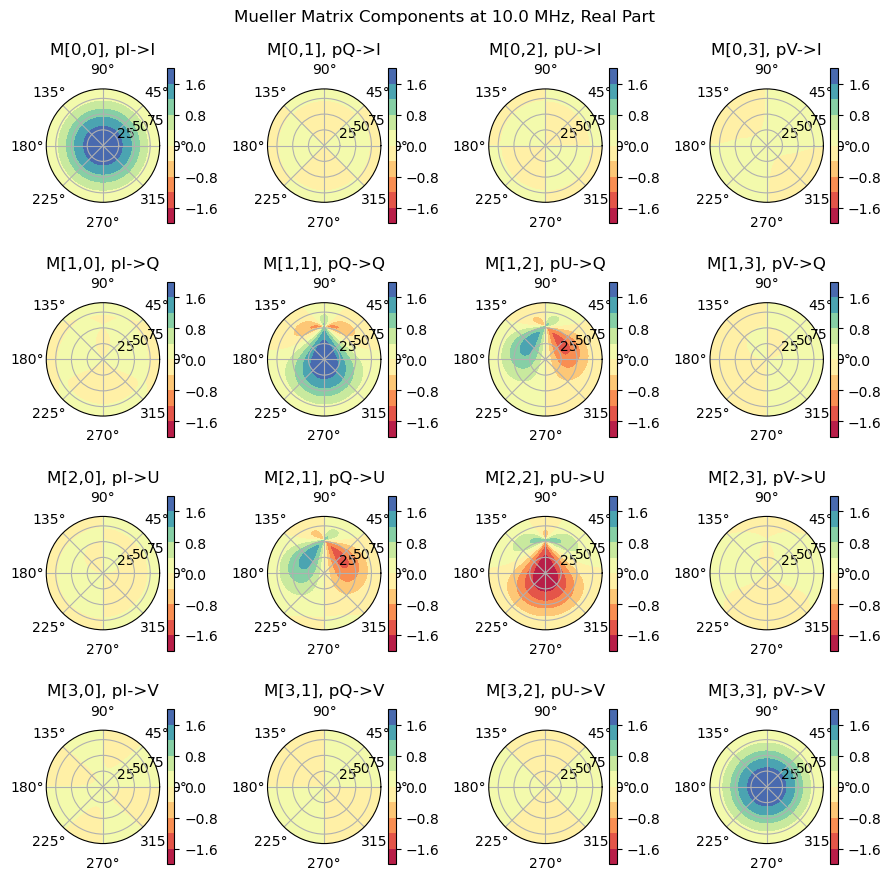

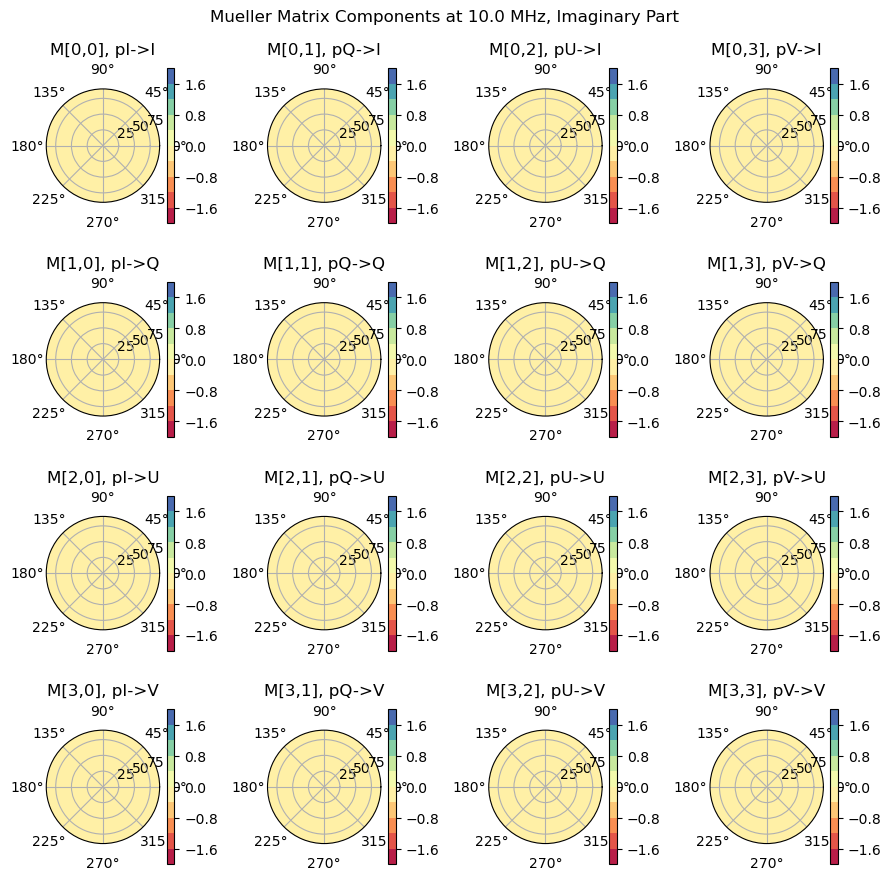

In [5]:
jones_to_mueller.plot_mueller_matrix(
    mueller_pstokes,  # pyuvdata beam object
    np.degrees(beam_radec.axis1_array),
    np.degrees(beam_radec.axis2_array),
    beam_radec.freq_array,
    plot_freq=10.0e6,  # frequency in Hz, must be included in the beam obj
    real_part=True,
    contour_plot=True,
    stokes=True,
    pseudostokes=True,
    vmin=-2,
    vmax=2,
)
jones_to_mueller.plot_mueller_matrix(
    mueller_pstokes,  # pyuvdata beam object
    np.degrees(beam_radec.axis1_array),
    np.degrees(beam_radec.axis2_array),
    beam_radec.freq_array,
    plot_freq=10.0e6,  # frequency in Hz, must be included in the beam obj
    real_part=False,
    contour_plot=True,
    stokes=True,
    pseudostokes=True,
    vmin=-2,
    vmax=2,
)

In [6]:
def zernike(n, m, za, theta):
    rho = np.sin(za)
    return zernike_radial_part(n, abs(m), rho) * zernike_azimuthal_part(m, theta)


def zernike_radial_part(n, m, rho):
    R0 = rho**m
    if n == m:
        return R0
    R2 = ((m + 2) * rho**2 - (m + 1)) * R0
    for n_prime in range(m + 4, n + 1, 2):
        recurrence_relation = (
            2
            * (n_prime - 1)
            * (2 * n_prime * (n_prime - 2) * rho**2 - m**2 - n_prime * (n_prime - 2))
            * R2
            - n_prime * (n_prime + m - 2) * (n_prime - m - 2) * R0
        ) / ((n_prime + m) * (n_prime - m) * (n_prime - 2))
        R0 = R2
        R2 = recurrence_relation
    return R2


def zernike_azimuthal_part(m, theta):
    if m == 0:
        return 1.0
    elif m > 0:
        return np.cos(m * theta)
    else:
        return np.sin(-m * theta)


def create_zernike_beam(az_values, za_values, zernike_coeffs, n_vals, m_vals):
    beam = np.zeros_like(az_values)
    for zernike_ind, coeff in enumerate(zernike_coeffs):
        beam += coeff * zernike(
            n_vals[zernike_ind],
            m_vals[zernike_ind],
            np.radians(za_values),
            np.radians(az_values),
        )
    return beam

In [7]:
az_axis = np.degrees(beam_radec.axis1_array)
za_axis = np.degrees(beam_radec.axis2_array)
za_vals, az_vals = np.meshgrid(za_axis, az_axis)
n_vals = [0, 2, 4, 4, 6, 6, 8, 8, 8]
m_vals = [0, 0, 0, 4, 0, 4, 0, 4, 8]
coeffs_52MHz = [ 
    0.5648697259136155,
    -0.45908927749490525,
    -0.03752995939112614,
    0.0033934821314708244,
    -0.030484384773088687,
    0.012225490320833442,
    -0.016913428790483902,  
    -0.004324269518531433,
    -0.013275940628521119,
]
coeffs_36MHz = [
    0.538556463745644,     -0.46866163121041965,
    -0.02903632892950315,   -0.008211454946665317,
    -0.02455123886166189,    0.010200717351278811,
    -0.002733004888223435,   0.012097962867146641,
    -0.010822907679258361
]
michael_beam = create_zernike_beam(az_vals, za_vals, coeffs_52MHz, n_vals, m_vals)

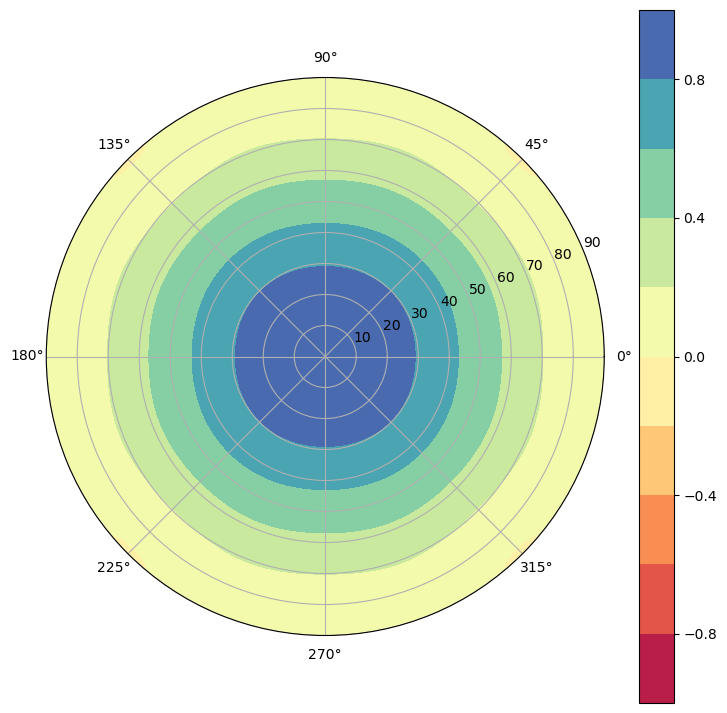

In [8]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, subplot_kw=dict(projection="polar"), figsize=(9, 9)
)
contourplot = jones_to_mueller.make_polar_contour_plot(
    ax,
    michael_beam,
    np.radians(az_vals),
    za_vals,
)
fig.colorbar(contourplot, ax=ax)
plt.show()

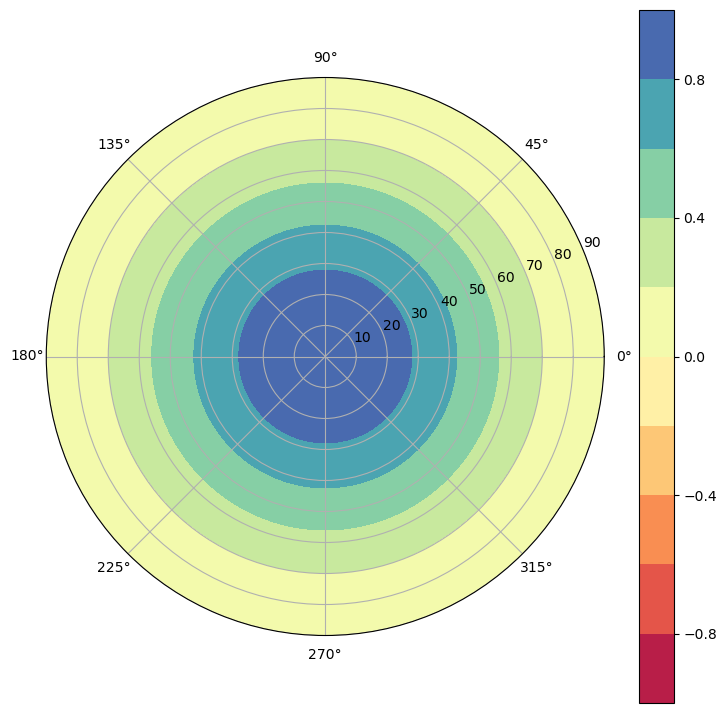

In [9]:
az_axis = np.degrees(beam_radec.axis1_array)
za_axis = np.degrees(beam_radec.axis2_array)
za_vals, az_vals = np.meshgrid(za_axis, az_axis)
fig, ax = plt.subplots(
    nrows=1, ncols=1, subplot_kw=dict(projection="polar"), figsize=(9, 9)
)
freq_ind = np.where(beam.freq_array[0, :] == 50e6)[0][0]
contourplot = jones_to_mueller.make_polar_contour_plot(
    ax,
    np.real(mueller_pstokes[0, 0, 0, freq_ind, :, :].T/2),
    np.radians(az_vals),
    za_vals,
)
fig.colorbar(contourplot, ax=ax)
plt.show()

In [19]:
def cost_function(coeffs, beam_vals, zernike_values_list):
    for coeff_ind in range(len(coeffs)):
        if coeff_ind == 0:
            zernike_beam = coeffs[coeff_ind] * zernike_values_list[coeff_ind]
        else:
            zernike_beam += coeffs[coeff_ind] * zernike_values_list[coeff_ind]
    cost = np.sum(np.abs(beam_vals-zernike_beam)**2.0)
    return cost

In [31]:
def fit_zernike_polynomials_to_beam(az_vals, za_vals, beam_vals, n_vals, m_vals):
    coeffs = np.zeros(len(n_vals), dtype=float)
    zernike_values_list = []
    for zernike_ind in range(len(n_vals)):
        zernike_values = zernike(
            n_vals[zernike_ind],
            m_vals[zernike_ind],
            np.radians(za_vals),
            np.radians(az_vals),
        )
        zernike_values_list.append(zernike_values)
        # coeffs[zernike_ind] = np.sum(beam_vals * zernike_values) / np.sum(
        #    np.abs(zernike_values) ** 2.0
        # )
    result = scipy.optimize.minimize(cost_function, coeffs, args=(beam_vals, zernike_values_list))
    coeffs_fit = result.x
    print(result.message)
    return coeffs_fit

In [40]:
az_axis = np.degrees(beam_radec.axis1_array)
za_axis = np.degrees(beam_radec.axis2_array)
za_vals, az_vals = np.meshgrid(za_axis, az_axis)
freq_ind = np.where(beam.freq_array[0, :] == 100e6)[0][0]
use_beam_vals = np.real(mueller_pstokes[0, 0, 0, freq_ind, :, :]).T / 2
coeffs = fit_zernike_polynomials_to_beam(
    az_vals, za_vals, use_beam_vals, n_vals, m_vals
)
print(coeffs)


Optimization terminated successfully.
[ 4.44059740e-01 -3.20106038e-01  1.05746608e-01 -1.91282229e-02
 -1.57187572e-01 -1.99417775e-03 -4.01687286e-02  1.34354027e-02
  1.74412740e-04]


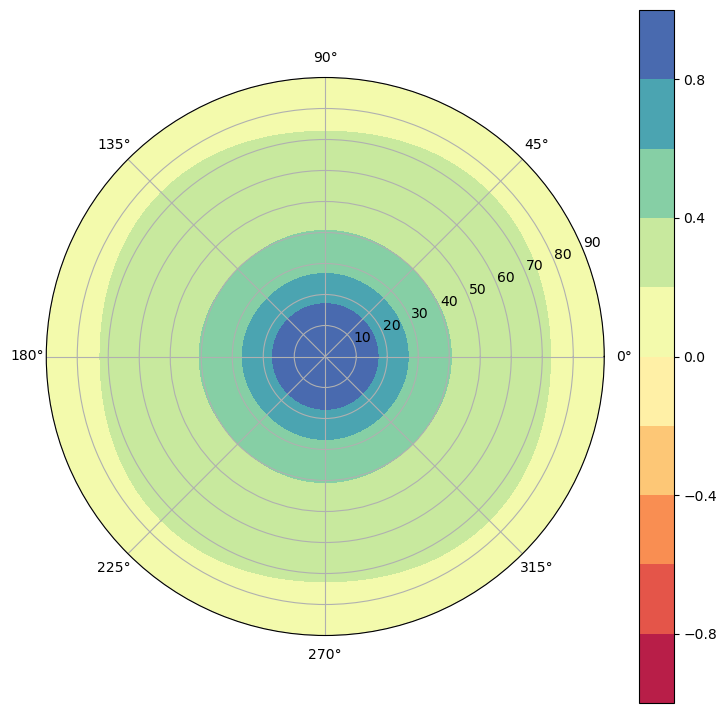

In [41]:
# Confirm coefficients
reconstructed_beam = create_zernike_beam(az_vals, za_vals, coeffs, n_vals, m_vals)
fig, ax = plt.subplots(
    nrows=1, ncols=1, subplot_kw=dict(projection="polar"), figsize=(9, 9)
)
contourplot = jones_to_mueller.make_polar_contour_plot(
    ax,
    reconstructed_beam,
    np.radians(az_vals),
    za_vals,
)
fig.colorbar(contourplot, ax=ax)
plt.show()

In [35]:
# Now step through all frequencies and perform fitting
az_axis = np.degrees(beam_radec.axis1_array)
za_axis = np.degrees(beam_radec.axis2_array)
za_vals, az_vals = np.meshgrid(za_axis, az_axis)
coeffs_all_frequencies = np.zeros((len(n_vals), beam.Nfreqs), dtype=float)
for freq_ind in range(beam.Nfreqs):
    use_beam_vals = np.real(mueller_pstokes[0, 0, 0, freq_ind, :, :]).T / 2
    coeffs = fit_zernike_polynomials_to_beam(
        az_vals, za_vals, use_beam_vals, n_vals, m_vals
    )
    coeffs_all_frequencies[:, freq_ind] = coeffs

Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.
Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Desired error not necessarily achieved due to precision loss.
Optimization terminated succes

In [37]:
for freq_ind in range(beam.Nfreqs):
    use_frequency = beam.freq_array[0, freq_ind]
    print(f"{use_frequency/1e6} MHz: {coeffs_all_frequencies[:, freq_ind]}")

10.0 MHz: [ 5.77178760e-01 -4.61309702e-01 -5.76621611e-02 -1.68871739e-05
 -3.16672096e-02 -8.17504908e-05 -1.53894508e-02  5.31914632e-05
  2.01614959e-08]
11.0 MHz: [ 5.74328311e-01 -4.62158179e-01 -5.56038736e-02  2.33317362e-05
 -3.11174714e-02 -1.27592979e-04 -1.48723553e-02  5.41868721e-05
  3.02967183e-08]
12.0 MHz: [ 5.71413387e-01 -4.62873418e-01 -5.34566989e-02  7.57659636e-05
 -3.06012273e-02 -1.83848359e-04 -1.44096165e-02  5.35640593e-05
  6.66415856e-08]
13.0 MHz: [ 5.68470832e-01 -4.63572513e-01 -5.12109051e-02  1.41697633e-04
 -3.00919722e-02 -2.51425136e-04 -1.39797228e-02  5.10428743e-05
  1.10985907e-07]
14.0 MHz: [ 5.65446854e-01 -4.64268862e-01 -4.88540223e-02  2.22521721e-04
 -2.95673558e-02 -3.31261746e-04 -1.35663074e-02  4.63192450e-05
  1.67326983e-07]
15.0 MHz: [ 5.62361000e-01 -4.65004892e-01 -4.63906300e-02  3.19415557e-04
 -2.90163733e-02 -4.23939965e-04 -1.31611058e-02  3.90108887e-05
  2.21469749e-07]
16.0 MHz: [ 5.59220233e-01 -4.65777564e-01 -4.384002